# The EOdal Mapper Class

## Learning Objectives

In this notebook you will learn about the capacities of the `Mapper` class in `EOdal`. In particular, you will

* query a Sentinel-2 cloud archive
* load and preprocess Sentinel-2 scenes into EOdal
* learn some basic things about the `SceneCollection` class

## Tutorial Pre-Requisites

You might check out how to work with [images](../General/Loading_Images.ipynb) first.
Basic knowledge about [Sentinel-2](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi) is helpful but not required.

# Introduction
The `Mapper` class is the heart of EOdal. It enables you to fetch vast amounts of Earth Observation data from local and cloud resources in an easy and intuitive manner.

In this notebook, you will learn how to use the `Mapper` class for fetching Sentinel-2 data.

In detail, you will learn how to use the EOdal Mapper class that takes over data handling such as

* querying of spatio-temporal metadata catalogs to identify available Sentinel-2 scenes
* merging data from different Sentinel-2 tiles if required
* re-projection of imagery from one UTM zone into another if required
* removal of black-filled (i.e., no-data) scenes

This notebook works by retrieving Sentinel-2 scenes from [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com) (no authentication required). Alternatively, the same code can be used to read data from a local EOdal Sentinel archive or a different STAC provider (e.g., AWS).

In [1]:
# some imports that we need later
import eodal
import geopandas as gpd
import os

from datetime import datetime
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs

from pathlib import Path
from typing import List


Settings = get_settings()
# set to False to use a local data archive
Settings.USE_STAC = True

# define the working directory
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent

print(f'EOdal version: {eodal.__version__}')

EOdal version: 0.2.2


The strength of the `Mapper` class is its ability to include custom `pre-processing` functions that tell the Mapper what to do with the scenes retrieved from an archive. The pre-processing function must take a `RasterCollection` or a sensor-specific class inheriting from `RasterCollection` as first argument. That's the only pre-requisite.

In our case, we want to bring all Sentinel-2 bands to a spatial resolution of 10m (i.e., we have to resample the 20m bands) and mask clouds and shadows using the Scene Classification Layer that is part of ESA's L2A product.

In [2]:
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
        interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True)
    return ds


## User Inputs
Now we have to tell EOdal

* what collection to use (this means which EO platform and sensor). The collections in EOdal follow the naming scheme `<platform>-<sensor>`.
* what time period to consider.
* the location we are interested in (can be a vector file, a shapely geometry or a geopandas GeoDataFrame or GeoSeries)
* further metadata filters such as cloud coverage, processing level and so on

We will use the `sentinel2-msi` collection (platform: sentinel2, sensor: msi), and extract scenes in L2A level (surface reflectance) for a region in southern Bavaria.

In [3]:
# -------------------------- Collection -------------------------------
collection: str = 'sentinel2-msi'

# ------------------------- Time Range ---------------------------------
time_start: datetime = datetime(2022,6,1)  # year, month, day (incl.)
time_end: datetime = datetime(2022,6,30)   # year, month, day (incl.)

# ---------------------- Spatial Feature  ------------------------------
geom: Path = base_dir.joinpath('data/sample_polygons/BY_AOI_2019_MNI_EPSG32632.shp')

# ------------------------- Metadata Filters ---------------------------
metadata_filters: List[Filter] = [
    Filter('cloudy_pixel_percentage','<', 10),
    Filter('processing_level', '==', 'Level-2A')
]

Geometries are handled by the `Feature` class.

In [4]:
#%% query the scenes available (no I/O of scenes, this only fetches metadata)
feature = Feature.from_geoseries(gpd.read_file(geom).dissolve().geometry)
feature

Name		geometry
Geometry	POLYGON ((694111.7334524073 5344355.003796914, 694111.7334524073 5355823.776519777, 707636.6606474974 5355823.776519777, 707636.6606474974 5344355.003796914, 694111.7334524073 5344355.003796914))
EPSG Code	32632
Attributes	{}

All user inputs are bundled in the `MapperConfig` class:

In [5]:
mapper_configs = MapperConfigs(
    collection=collection,
    time_start=time_start,
    time_end=time_end,
    feature=feature,
    metadata_filters=metadata_filters
)

To enhance reproducibility and provide proper documentation, the `MapperConfigs` can be saved as `yaml` file (and also then be loaded again from yaml file).

In [6]:
mapper_configs.to_yaml(base_dir.joinpath('data/sample_mapper_call.yaml'))

## Executing the Mapper

The mapper is now ready to fetch scenes. First, it queries the metadata to find available data.

In [7]:
mapper = Mapper(mapper_configs)
mapper

EOdal Mapper
EOdal MapperConfig
------------------
Collection: sentinel2-msi
Time Range: 2022-06-01 00:00:00 - 2022-06-30 00:00:00
Feature:
Name		geometry
Geometry	POLYGON ((694111.7334524073 5344355.003796914, 694111.7334524073 5355823.776519777, 707636.6606474974 5355823.776519777, 707636.6606474974 5344355.003796914, 694111.7334524073 5344355.003796914))
EPSG Code	32632
Attributes	{}
Metadata Filters: [cloudy_pixel_percentage < 10, processing_level == Level-2A]
Data Source: STAC (https://planetarycomputer.microsoft.com/api/stac/v1)

Query the catalog and fetch the metadata. The metadata is loaded as a `GeoDataFrame`.

In [8]:
mapper.query_scenes()
mapper.metadata

product_uri  \
4  S2B_MSIL2A_20220612T100559_R022_T32UQU_2022061...   
5  S2B_MSIL2A_20220612T100559_R022_T32UPU_2022061...   
3  S2B_MSIL2A_20220615T101559_R065_T32UQU_2022061...   
1  S2A_MSIL2A_20220627T100611_R022_T32UQU_2022062...   
2  S2A_MSIL2A_20220627T100611_R022_T32UPU_2022062...   
0  S2A_MSIL2A_20220630T102041_R065_T32UQU_2022070...   

                                            scene_id spacecraft_name tile_id  \
4  S2B_OPER_MSI_L2A_TL_ESRI_20220613T070518_A0275...     Sentinel-2B   32UQU   
5  S2B_OPER_MSI_L2A_TL_ESRI_20220613T065936_A0275...     Sentinel-2B   32UPU   
3  S2B_OPER_MSI_L2A_TL_ESRI_20220616T073000_A0275...     Sentinel-2B   32UQU   
1  S2A_OPER_MSI_L2A_TL_ESRI_20220628T035624_A0366...     Sentinel-2A   32UQU   
2  S2A_OPER_MSI_L2A_TL_ESRI_20220628T043033_A0366...     Sentinel-2A   32UPU   
0  S2A_OPER_MSI_L2A_TL_ESRI_20220701T025409_A0366...     Sentinel-2A   32UQU   

  sensing_date  cloudy_pixel_percentage   epsg  \
4   2022-06-12                 4.293470  32632   
5   2022-06-12                 3.358357  32632   
3   2022-06-15                 2.739887  32632   
1   2022-06-27                 0.001606  32632   
2   2022-06-27                 0.012403  32632   
0   2022-06-30                 8.423131  32632   

                      sensing_time  sun_azimuth_angle  sun_zenith_angle  \
4 2022-06-12 10:05:59.024000+00:00         152.682806         27.143967   
5 2022-06-12 10:05:59.024000+00:00         150.210972         27.596925   
3 2022-06-15 10:15:59.025000+00:00         157.118307         26.337107   
1 2022-06-27 10:06:11.024000+00:00         151.131583         27.242381   
2 2022-06-27 10:06:11.024000+00:00         148.690409         27.715687   
0 2022-06-30 10:20:41.025000+00:00         155.725244         26.692577   

                                                geom  \
4  POLYGON ((11.719 48.721, 13.208 48.676, 13.128...   
5  POLYGON ((10.583 47.753, 10.631 47.885, 10.685...   
3  POLYGON ((12.577 48.695, 12.527 48.589, 12.460...   
1  POLYGON ((11.719 48.721, 13.208 48.676, 13.128...   
2  POLYGON ((10.580 47.753, 10.602 47.814, 10.656...   
0  POLYGON ((12.572 48.695, 12.545 48.637, 12.478...   

                                              assets  
4  {'AOT': {'href': 'https://sentinel2l2a01.blob....  
5  {'AOT': {'href': 'https://sentinel2l2a01.blob....  
3  {'AOT': {'href': 'https://sentinel2l2a01.blob....  
1  {'AOT': {'href': 'https://sentinel2l2a01.blob....  
2  {'AOT': {'href': 'https://sentinel2l2a01.blob....  
0  {'AOT': {'href': 'https://sentinel2l2a01.blob....

Next, we can load the actual data, i.e., the Sentinel-2 scenes. The Mapper class is very flexible in this regard, meaning users can provide their custom functions how to read and process scenes.

In our case, we tell EOdal to read Sentinel-2 scenes using the `Sentinel2.from_safe` method (see also [the notebook about Sentinel-2](../Sentinel2/sentinel2_data_handling.ipynb)), load the visible bands (B02,B03,B04), and pre-process the scenes using the preprocessing function defined above.

In [9]:
scene_kwargs = {
    'scene_constructor': Sentinel2.from_safe,
    'scene_constructor_kwargs': {'band_selection': ['B02', 'B03', 'B04']},
    'scene_modifier': preprocess_sentinel2_scenes,
    'scene_modifier_kwargs': {'target_resolution': 10}
}

Now, we query the Sentinel-2 scenes and load them into the `data` attribute. The scenes are loaded into a `EOdal` `SceneCollection`.

In [10]:
mapper.load_scenes(scene_kwargs=scene_kwargs)

2023-08-24 16:02:55,707 eodal        INFO     Starting extraction of sentinel2 scenes
2023-08-24 16:03:37,546 eodal        INFO     Finished extraction of sentinel2 scenes


In [11]:
mapper.data

EOdal SceneCollection
----------------------
# Scenes:    4
Timestamps:    2022-06-12 10:05:59, 2022-06-15 10:15:59, 2022-06-27 10:06:11, 2022-06-30 10:20:41
Scene Identifiers:    S2B_MSIL2A_20220612T100559_N0400_R022_T32UQU_20220613T070516.SAFE&&S2B_MSIL2A_20220612T100559_N0400_R022_T32UPU_20220613T065934.SAFE, S2B_MSIL2A_20220615T101559_N0400_R065_T32UQU_20220616T072958.SAFE, S2A_MSIL2A_20220627T100611_N0400_R022_T32UQU_20220628T035623.SAFE&&S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220628T043031.SAFE, S2A_MSIL2A_20220630T102041_N0400_R065_T32UQU_20220701T025408.SAFE

We can visualize the scenes in the `SceneCollection`. You will see that the `Mapper` class has reduced the amount of scenes found (8) to 4 as the selected region lies in the overlapping region between two Sentinel-2 tiles. The `Mapper` handles this overlap automatically and merges the data from both tiles to generate seamless scenes. You can see that the `Scene_Identifiers` have a `&` which means the scene was merged by the `EOdal` `Mapper` in the background.

/mnt/ides/Lukas/software/eodal_notebooks/.venv/lib64/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


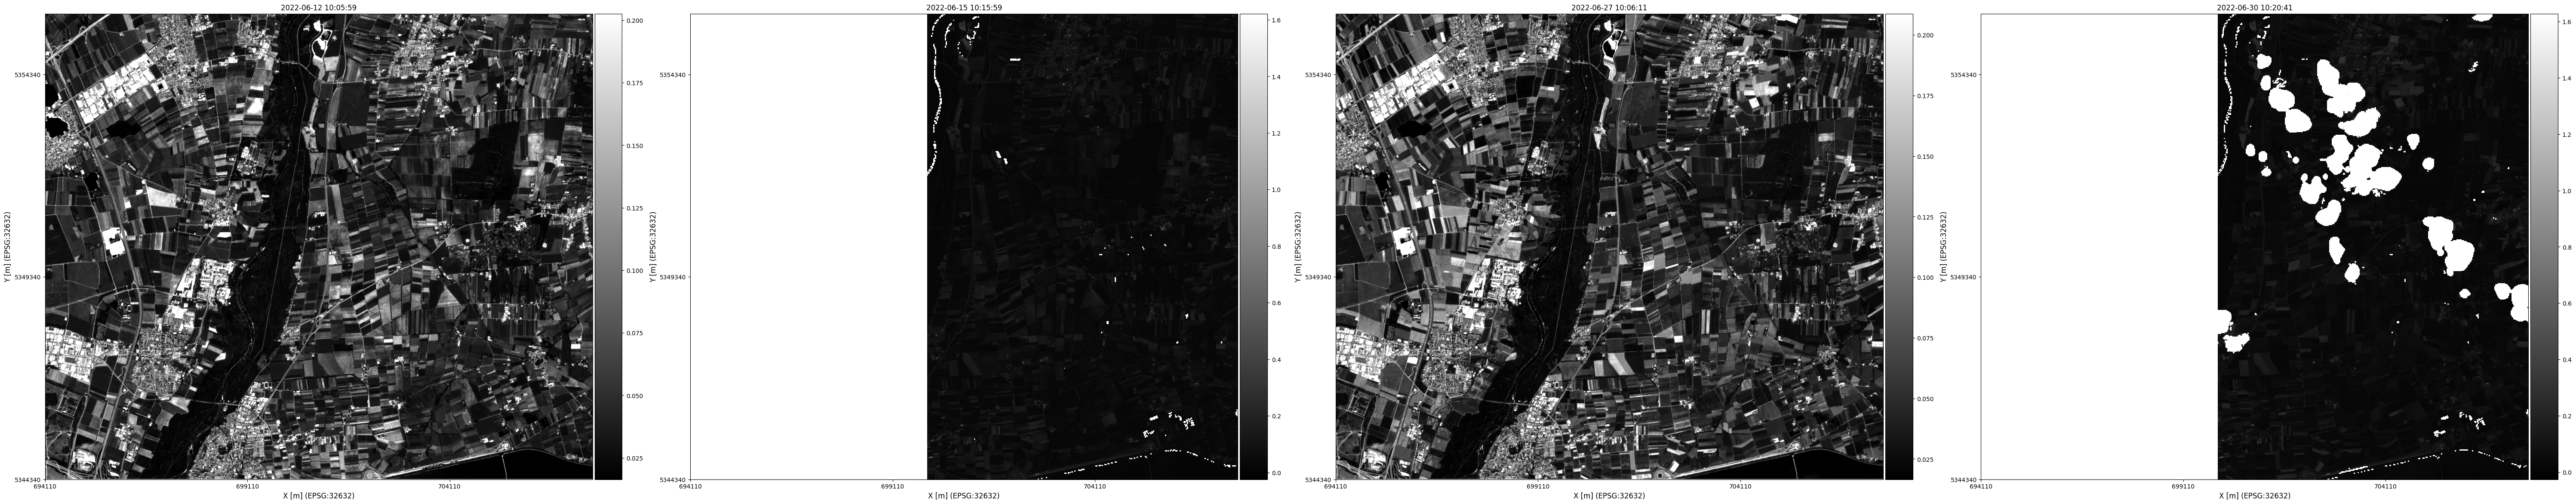

In [12]:
import matplotlib.pyplot as plt
f_scenes = mapper.data.plot(band_selection=['red'], figsize=(60,20))

## Making Mapper Results Persistent

`EOdal SceneCollections` can be made persistent by storing them as serialized pickled objects on disk (and can be loaded from there). Thus, significant amounts of time can be saved as data extraction and processing routines have not necessarily to be repeated.

In [13]:
fpath = base_dir.joinpath('data/sample_mapper_data.pkl')
with open(fpath, 'wb+') as dst:
    dst.write(mapper.data.to_pickle())

# read data from pickled file object into SceneCollectio
scoll = SceneCollection.from_pickle(stream=fpath)
scoll

EOdal SceneCollection
----------------------
# Scenes:    4
Timestamps:    2022-06-12 10:05:59, 2022-06-15 10:15:59, 2022-06-27 10:06:11, 2022-06-30 10:20:41
Scene Identifiers:    S2B_MSIL2A_20220612T100559_N0400_R022_T32UQU_20220613T070516.SAFE&&S2B_MSIL2A_20220612T100559_N0400_R022_T32UPU_20220613T065934.SAFE, S2B_MSIL2A_20220615T101559_N0400_R065_T32UQU_20220616T072958.SAFE, S2A_MSIL2A_20220627T100611_N0400_R022_T32UQU_20220628T035623.SAFE&&S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220628T043031.SAFE, S2A_MSIL2A_20220630T102041_N0400_R065_T32UQU_20220701T025408.SAFE